In [1]:
# Bank of Functions

def haversine_vectorize(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return round(km,2)

def get_haversine(df):
    n1 = (df['start_node'].y, df['start_node'].x) # (lat, lon)
    n2 = (df['end_node'].y, df['end_node'].x)
    dist = haversine(n1, n2)
    return dist
                 
def get_corrected_distance(x):
    if(x['euclidean_distance'])<=1:
        return x['euclidean_distance']
    else:
        if (x['road_dist_pop']>=x['euclidean_distance']):
            return x['euclidean_distance']
        else:
            return x['travel_distance']
        
def getvariables(n, m, X, Y):
    
    import numpy as np
    
    Xvalues = np.zeros(m)
    Yvalues = np.zeros(n+m)
    for i in range(m):
        Xvalues[i]=X[i].x
    for i in range(n):
        Yvalues[i]=Y[i].x
    
    return(Xvalues, Yvalues)

def OptimizationModel(array_household, current_hospitals_ID, new_hospitals_ID, 
                      distance_matrix, S, hosp_count, mipGap=.001, trace=False):
    
    import time
    import gurobipy as gb
    from gurobipy import GRB
    import numpy as np
    import pandas as pd
    
    #Data preprocessing
    tstart = time.time()
    obj_val_array = []
    existinghosp = len(current_hospitals_ID)
    m = len(current_hospitals_ID) + len(new_hospitals_ID)
    n = len(array_household)
    p = existinghosp + 0       #total number of hospitals to be optimized
    
    # Only keep the combinations of houses/hospitals which are less or equal to the maximum distance
    dist = distance_matrix[distance_matrix.distance<=S]
    
    # collect the indices of the distances below the threshold 
    II = dist['pop_id']
    JJ = dist['fac_id']
    
    IJ = { i : set() for i in range(n) }
    for i,j in zip(II,JJ):
        IJ[i].add(j) 
    
    # Create the model
    M = gb.Model("Facility location problem")
    
    M.Params.OutputFlag = trace 
    M.Params.mipgap     = mipGap
    
    # Decision variables
    X = M.addVars(m, vtype=GRB.BINARY)
    Y = M.addVars(n, vtype=GRB.BINARY)
    
    # Objective
    obj = gb.LinExpr( array_household, Y.select('*') )
    M.setObjective(obj, gb.GRB.MAXIMIZE)
    
    # Constraints
    # Set existing hospitals to one
    M.addConstrs(X[j] == 1 for j in current_hospitals_ID)

    # Limit number of hospitals a household is connected to, let a household only connect to an opened facility
    M.addConstrs((Y[i] <= (gb.quicksum(X[j] for j in IJ[i]))) for i in range(n))
#     M.addConstrs(Y[i] <= (gb.quicksum(X[j] for j in dist['HospCluster'].loc[dist['Pop_ID']==i])) for i in range(n))

    
    # Limit number of facilities located 
    s = M.addLConstr(gb.quicksum(X[j] for j in range(m))<= p)
    
    modelling_time = time.time()-tstart
    tstart = time.time()
    
    # Optimize the model and extract solution
    M.optimize() 
    obj_val = M.objVal
    Xvalues, Yvalues = getvariables(n, m, X, Y)

    obj_val_array.append([S,0,obj_val,list(Xvalues),list(Yvalues)])
    
    
    
    # Iterate for multiple additional hospital facilities
    for each_hosp_count in hosp_count:
        M.remove(s)
        p = existinghosp + each_hosp_count
        s = M.addConstr(gb.quicksum(X[j] for j in range(m))<= p, name = "Budget")
        
        M.optimize()
        obj_val = M.objVal
        Xvalues, Yvalues = getvariables(n, m, X, Y)

        obj_val_array.append([S,each_hosp_count,obj_val,list(Xvalues),list(Yvalues)])
    
    solving_time = time.time() - tstart 
    
    df_opt_array = pd.DataFrame(obj_val_array)
    df_opt_array.columns = ['km','number_of_new_hospitals','count','array_hosp','array_hh']
    df_opt_array['number_of_hospitals'] = df_opt_array['number_of_new_hospitals']+existinghosp
    df_opt_array['%'] = df_opt_array['count']*100/sum(array_household)
    df_opt_array['%'] = df_opt_array['%'].round(1)
    
    return df_opt_array, modelling_time, solving_time

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import sqlite3
import re
import folium 
from folium import features

from shapely.geometry import Point, LineString, shape
import shapely
import geopandas as gpd

from pyproj import Transformer
from shapely.ops import transform

import xarray as xr

import plotly.express as px

import bisect

import plotly.figure_factory as ff
import plotly.graph_objects as go


import json


import rasterio
from rasterio.plot import show    
import rioxarray as rxr

from rasterstats import zonal_stats
    
import numpy as np

from IPython.display import HTML
from IPython.display import HTML as html_print

from haversine import haversine_vector, haversine

import pandana

import pyproj

from gurobipy import Model, GRB
import plotly.graph_objects as go

# Added by Joaquim

In [6]:
from tqdm.notebook import tqdm

import sys
sys.path.append('../../optimization')

%load_ext autoreload
%autoreload 2

import maxcovering as mc
import optdata as od

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%%time

road_asset_gdf = gpd.read_file('data/road_estrada_new.geojson')
road_asset_gdf.crs = "EPSG:4326"

gdf = road_asset_gdf.to_crs(epsg=3844)
gdf['length_code'] = gdf['geometry'].length
gdf['length_code'] = gdf['length_code'].round()
gdf['length_code'] = gdf['length_code']/1000

road_asset_gdf['length_km'] = gdf['length_code']

print('Estrada Road Network Data : ', round(road_asset_gdf['length_km'].sum()), 'km')

Estrada Road Network Data :  17390 km
CPU times: total: 54.5 s
Wall time: 55.9 s


In [8]:
distance_km = 10

In [9]:
road_network = road_asset_gdf

In [10]:
%%time 

road_network['start_node'] = road_network['geometry'].apply(lambda x: Point(x.xy[0][0], x.xy[1][0]) if isinstance(x, LineString) else None)
road_network['end_node'] = road_network['geometry'].apply(lambda x: Point(x.xy[0][-1], x.xy[1][-1]) if isinstance(x, LineString) else None)


CPU times: total: 28.3 s
Wall time: 29.5 s


In [11]:
%%time

node_list = []
for each_val in road_network['start_node'].unique():
    node_list.append(each_val)
for each_val in road_network['end_node'].unique():
    node_list.append(each_val)

df_nodes = gpd.GeoDataFrame(node_list,columns=['geometry'])
df_nodes = gpd.GeoDataFrame(list(df_nodes['geometry'].unique()),columns=['geometry'])
df_nodes['x'] = df_nodes['geometry'].x
df_nodes['y'] = df_nodes['geometry'].y

df_edge_subset = df_nodes.reset_index()[['index','geometry']]
df_edge_subset.columns = ['nodeID','node_geometry']

df_edges = pd.merge(road_network,df_edge_subset,left_on='start_node',right_on='node_geometry')
df_edges = pd.merge(df_edges,df_edge_subset,left_on='end_node',right_on='node_geometry')

df_dist = df_edges[['start_node','end_node']].drop_duplicates()
df_dist['len_km'] = df_dist.apply(get_haversine,axis=1)

df_edges = pd.merge(df_edges,df_dist,on=['start_node','end_node'])

network = pandana.Network(df_nodes['x'], df_nodes['y'], 
                          df_edges['nodeID_x'], df_edges['nodeID_y'], df_edges[['len_km']],twoway=True)


CPU times: total: 1min 20s
Wall time: 1min 17s


In [12]:
population = pd.read_csv('data/ppp_TLS_2020_1km_Aggregated_UNadj.csv')
population.columns = ['lon','lat','population']
pop_gdf = gpd.GeoDataFrame(population, geometry=gpd.points_from_xy(population.lon, population.lat))
pop_gdf = pop_gdf[pop_gdf['population']>0]
pop_gdf.crs = "EPSG:4326"

print('Population:', round(pop_gdf['population'].sum()/1000000,2), 'million')

pop_gdf['pop_color'] = pd.qcut(pop_gdf['population'],4, labels=['#ffffcc', '#a1dab4', '#41b6c4', '#225ea8'])

pop_gdf = pop_gdf.reset_index()
pop_gdf.rename(columns={'index':'pop_id'},inplace=True)

pop_gdf = pop_gdf[['pop_id','lat','lon','population','geometry','pop_color']].reset_index()
pop_gdf = pop_gdf.reset_index()
del pop_gdf['index']
del pop_gdf['pop_id']
pop_gdf.rename(columns={'level_0':'pop_id'},inplace=True) 

pop_gdf['nearest_node_pop'] = network.get_node_ids(pop_gdf['lon'], 
                                                    pop_gdf['lat'], mapping_distance=1000)

pop_gdf = pd.merge(pop_gdf,df_nodes.reset_index()[['index','x','y']],left_on='nearest_node_pop',
                        right_on='index')
pop_gdf['road_dist_pop'] = haversine_vectorize(pop_gdf['lon'],pop_gdf['lat'],
                                                        pop_gdf['x'],pop_gdf['y'])
pop_gdf = pop_gdf[['pop_id','geometry','lat','lon','population','pop_color',
                   'nearest_node_pop','road_dist_pop']]

pop_gdf = pop_gdf.sort_values('pop_id')

Population: 1.32 million


In [13]:
health_sites = gpd.read_file('data/health_sites_who.geojson')
health_sites = health_sites[['LAT','LONG','L_NAME','geometry','CLASS']].reset_index()
health_sites['lat'] = health_sites['geometry'].apply(lambda x:x.y) 
health_sites['lon'] = health_sites['geometry'].apply(lambda x:x.x) 
health_sites.rename(columns={'index':'fac_id','L_NAME':'name'},inplace=True) 
del health_sites['LAT'] 
del health_sites['LONG']
del health_sites['CLASS']

health_sites['nearest_node_fac'] = network.get_node_ids(health_sites['lon'], 
                                                    health_sites['lat'], mapping_distance=1000)

health_sites = pd.merge(health_sites,df_nodes.reset_index()[['index','x','y']],left_on='nearest_node_fac',
                        right_on='index')

health_sites['road_dist_fac'] = haversine_vectorize(health_sites['lon'],health_sites['lat'],
                                                        health_sites['x'],health_sites['y'])
health_sites = health_sites[['fac_id','name','geometry','lat','lon','nearest_node_fac','road_dist_fac']]


In [14]:
%%time 

buffer_hospitals = health_sites[['fac_id','geometry']]
buffer_hospitals['geometry'] = health_sites[['fac_id',
                                             'geometry']].to_crs('EPSG:32610').buffer(distance_km*1000).to_crs('EPSG:4326').reset_index()[0]

points_within_polygon = gpd.sjoin(pop_gdf, buffer_hospitals, op='within')
points_within_polygon = points_within_polygon[['fac_id','pop_id']]

buffered_pop = points_within_polygon.groupby('fac_id')['pop_id'].apply(list).reset_index()
buffered_pop.columns = ['fac_id','pop_with_euclidean_buffer']

df_access_fac = pd.merge(health_sites,buffered_pop,on='fac_id')


CPU times: total: 78.1 ms
Wall time: 78 ms


In [15]:
travel_dist = df_access_fac[['fac_id','lat','lon',
                             'pop_with_euclidean_buffer',
                             'nearest_node_fac','road_dist_fac']].explode('pop_with_euclidean_buffer')

travel_dist.rename(columns={'lat':'lat_fac'},inplace=True)
travel_dist.rename(columns={'lon':'lon_fac'},inplace=True)

travel_dist = pd.merge(travel_dist,pop_gdf[['pop_id','lon','lat','population','nearest_node_pop','road_dist_pop']],
         left_on='pop_with_euclidean_buffer',right_on='pop_id')
travel_dist.rename(columns={'lat':'lat_pop'},inplace=True)
travel_dist.rename(columns={'lon':'lon_pop'},inplace=True)

travel_dist['travel_path_km'] = network.shortest_path_lengths(travel_dist['nearest_node_fac'],
                                                              travel_dist['nearest_node_pop'])

travel_dist['travel_distance'] = travel_dist['road_dist_fac']+travel_dist['road_dist_pop']+travel_dist['travel_path_km']

travel_dist['euclidean_distance'] = haversine_vectorize(travel_dist['lon_pop'],travel_dist['lat_pop'],
                                                        travel_dist['lon_fac'],travel_dist['lat_fac'])

In [16]:
travel_dist['travel_distance_corrected'] = travel_dist[['road_dist_pop','euclidean_distance',
                                                           'travel_distance']].apply(get_corrected_distance,
                                                                                            axis=1)


# Added by Joaquim

I noticed that line geometries from the road network have been replaced by straight lines. 
I got curious about the effect.

## I learnt this from ChatGPT

EPSG:4326, also known as WGS 84 (World Geodetic System 1984), is a geographic coordinate system based on latitude and longitude. It's often used to represent locations on the Earth's surface as spherical coordinates.

While EPSG:4326 can be used for mapping and analysis in Timor-Leste, it's not the most suitable coordinate system if you need to perform accurate distance measurements or area calculations, especially over larger distances. Geographic coordinate systems like EPSG:4326 introduce distortion when measuring distances due to the spherical shape of the Earth, which can lead to inaccuracies.

Using a projected coordinate system like UTM (EPSG:32752 or EPSG:32753) would provide more accurate measurements for distances and areas, as it minimizes distortion within a specific zone. UTM zones are designed for accurate measurement within their respective zones, making them more appropriate for tasks that involve quantitative analysis or precise measurements.

However, if your work primarily involves visual representation, and you're not concerned with high-precision measurements, EPSG:4326 could still be used for mapping purposes in Timor-Leste. It's essential to consider the nature of your project and the level of accuracy required for your analysis when selecting a coordinate system.

In [17]:
def sorting_key(row):
    return (row['start_node'].x, row['start_node'].y, row['end_node'].x, row['end_node'].y)

idx_road_network = sorted(range(len(road_network)), key=lambda i: sorting_key(road_network.iloc[i]))
idx_edges = sorted(range(len(df_edges)), key=lambda i: sorting_key(df_edges.iloc[i]))


In [18]:
pd.DataFrame( [road_network.iloc[idx_road_network].geometry.to_crs('EPSG:32752').length.values, ( df_edges.iloc[idx_edges].len_km * 1000 ).values] ).T

,0,1
0,22.494316,22.420943
1,31.352072,31.275937
2,57.523718,57.418381
3,61.078341,60.949410
4,75.728029,75.566194
...,...,...
405519,58.399550,58.696424
405520,9.791653,9.839349
405521,29.509185,29.648196
405522,58.907360,59.205182


In [19]:
perc_result = []

for each_val in [2,5,10]:
    pop_with_access = travel_dist[travel_dist['travel_distance_corrected']<=each_val]
    pop_test = list(pop_with_access['pop_id'].unique())
    sel_pop = pop_gdf[pop_gdf['pop_id'].isin(pop_test)]
    not_sel_pop = pop_gdf[~pop_gdf['pop_id'].isin(pop_test)]
    pop_access_perc = ((sel_pop['population'].sum().round()/pop_gdf['population'].sum().round())*100).round(2)
    perc_result.append([each_val,pop_access_perc])

df_perc_result = pd.DataFrame(perc_result)
df_perc_result.columns = ['Distance(km)','% of population with access']
df_perc_result

,Distance(km),% of population with access
0,2,37.54
1,5,66.40
2,10,76.22


In [20]:
current_facs = travel_dist[['fac_id','pop_id','travel_distance_corrected']]

In [21]:
#current_facs.to_pickle('ForOptimization/WP_currentfacs.pkl')

In [22]:
%%time 

potential_locs = gpd.read_file('data/potential_loc_grid1km.geojson')
potential_locs = potential_locs.to_crs("EPSG:4326")[['id','geometry']].reset_index()
potential_locs = potential_locs[['index','geometry']]
potential_locs['Latitude'] = potential_locs['geometry'].apply(lambda x:x.y)
potential_locs['Longitude'] = potential_locs['geometry'].apply(lambda x:x.x)
potential_locs.rename(columns={'index':'fac_id'},inplace=True)

potential_locs['nearest_node_fac'] = network.get_node_ids(potential_locs['Longitude'], 
                                                    potential_locs['Latitude'], mapping_distance=1000)

potential_locs = pd.merge(potential_locs,df_nodes.reset_index()[['index','x','y']],left_on='nearest_node_fac',
                        right_on='index')

potential_locs['road_dist_fac'] = haversine_vectorize(potential_locs['Longitude'],potential_locs['Latitude'],
                                                        potential_locs['x'],potential_locs['y'])

potential_locs = potential_locs[['fac_id','geometry','Latitude','Longitude','nearest_node_fac','road_dist_fac']]


CPU times: total: 1.8 s
Wall time: 1.81 s


In [23]:
%%time 

buffer_hospitals = potential_locs[['fac_id','geometry']]
buffer_hospitals['geometry'] = potential_locs[['fac_id',
                                             'geometry']].to_crs('EPSG:32610').buffer(distance_km*1000).to_crs('EPSG:4326').reset_index()[0]

points_within_polygon = gpd.sjoin(pop_gdf, buffer_hospitals, op='within')
points_within_polygon = points_within_polygon[['fac_id','pop_id']]

buffered_pop = points_within_polygon.groupby('fac_id')['pop_id'].apply(list).reset_index()
buffered_pop.columns = ['fac_id','pop_with_euclidean_buffer']

df_access_fac = pd.merge(potential_locs,buffered_pop,on='fac_id')




CPU times: total: 1.94 s
Wall time: 1.94 s


In [24]:
travel_dist = df_access_fac[['fac_id','Latitude','Longitude',
                             'pop_with_euclidean_buffer',
                             'nearest_node_fac','road_dist_fac']].explode('pop_with_euclidean_buffer')

travel_dist.rename(columns={'Latitude':'lat_fac'},inplace=True)
travel_dist.rename(columns={'Longitude':'lon_fac'},inplace=True)

travel_dist = pd.merge(travel_dist,pop_gdf[['pop_id','lon','lat',
                                            'population','nearest_node_pop','road_dist_pop']],
                       
         left_on='pop_with_euclidean_buffer',right_on='pop_id')
travel_dist.rename(columns={'lat':'lat_pop'},inplace=True)
travel_dist.rename(columns={'lon':'lon_pop'},inplace=True)

travel_dist['travel_path_km'] = network.shortest_path_lengths(travel_dist['nearest_node_fac'],
                                                              travel_dist['nearest_node_pop'])

travel_dist['travel_distance'] = travel_dist['road_dist_fac']+travel_dist['road_dist_pop']+travel_dist['travel_path_km']

travel_dist['euclidean_distance'] = haversine_vectorize(travel_dist['lon_pop'],travel_dist['lat_pop'],
                                                        travel_dist['lon_fac'],travel_dist['lat_fac'])

In [25]:
travel_dist['travel_distance_corrected'] = travel_dist[['road_dist_pop','euclidean_distance',
                                                           'travel_distance']].apply(get_corrected_distance,
                                                                                            axis=1)


In [26]:
perc_result = []

for each_val in [2,5,10]:
    pop_with_access = travel_dist[travel_dist['travel_distance_corrected']<=each_val]
    pop_test = list(pop_with_access['pop_id'].unique())
    sel_pop = pop_gdf[pop_gdf['pop_id'].isin(pop_test)]
    not_sel_pop = pop_gdf[~pop_gdf['pop_id'].isin(pop_test)]
    pop_access_perc = ((sel_pop['population'].sum().round()/pop_gdf['population'].sum().round())*100).round(2)
    perc_result.append([each_val,pop_access_perc])

df_perc_result = pd.DataFrame(perc_result)
df_perc_result.columns = ['Distance(km)','% of population with access']
df_perc_result

,Distance(km),% of population with access
0,2,100.0
1,5,100.0
2,10,100.0


In [27]:
potential_facs = travel_dist[['fac_id','pop_id','travel_distance_corrected']]

In [28]:
potential_facs.to_pickle('ForOptimization/WP_potentialfacs.pkl')

In [29]:
pop_gdf.to_pickle('ForOptimization/WP_population.pkl')

In [30]:
current_facs = current_facs.round()
potential_facs = potential_facs.round()

In [31]:
potential_facs['fac_id'] = potential_facs['fac_id']+current_facs['fac_id'].max()+1


In [32]:
df_combined = pd.concat([current_facs, potential_facs],axis=0)
df_combined.columns = ['fac_id','pop_id','distance']

In [33]:
pop_gdf.sort_values(by='pop_id')['population'].values.round().astype(int)

array([ 9, 39, 27, ..., 34, 41, 37])

In [34]:
%%time

budget = [5,10,20,30,40,50,60,70,80,90,100,150,200,250,300,400,500,750,1000,2000]

array_household = pop_gdf.sort_values(by='pop_id')['population'].values.round().astype(int)
current_hospitals_ID = current_facs['fac_id'].unique()
new_hospitals_ID = potential_facs['fac_id'].unique()
    
df_combined_output = pd.DataFrame()
for each_threshold in [2,5,10]:
    opt_array, tModelling, tSolving = OptimizationModel(array_household, current_hospitals_ID, 
                                                        new_hospitals_ID, df_combined, each_threshold, 
                                                        budget)
    
    df_opt_outputs = pd.DataFrame(opt_array)
    
    df_combined_output = pd.concat([df_combined_output,df_opt_outputs])
    print("Threshold distance: " + str(each_threshold))
    print("Solving time: " + str(tSolving/60) + ", modelling time: " + str(tModelling/60))
    

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-02
Threshold distance: 2
Solving time: 0.47304365237553914, modelling time: 0.009496704737345377
Threshold distance: 5
Solving time: 0.4529760479927063, modelling time: 0.010958313941955566
Threshold distance: 10
Solving time: 0.49960144360860187, modelling time: 0.013271152973175049
CPU times: total: 2min 33s
Wall time: 1min 27s


In [35]:
df_combined_output['%'] = df_combined_output['%'].round()

In [36]:
df_combined_output

,km,number_of_new_hospitals,count,array_hosp,array_hh,number_of_hospitals,%
0,2,0,574316.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",347,44.0
1,2,5,636869.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0...",352,48.0
2,2,10,656899.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",357,50.0
3,2,20,686983.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0...",367,52.0
4,2,30,710692.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",377,54.0
...,...,...,...,...,...,...,...
16,10,400,1315811.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",747,100.0
17,10,500,1317157.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",847,100.0
18,10,750,1317157.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1097,100.0
19,10,1000,1317157.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1347,100.0


In [37]:
fig = px.line(df_combined_output.sort_values(by=['km','number_of_hospitals']),
              x='number_of_hospitals',y='%',color='km',
              labels={
                     "number_of_hospitals": "Number of Health Facilities",
                     "%": "Percentage of households with access",
                     "km": "Distance (KM)"
                 })
fig.update_xaxes(range=[0, 2500])
fig.update_yaxes(range=[0, 110])

fig.add_annotation(x=165, y=105,
                   text="Current health facilities:"+str(current_facs['fac_id'].nunique()),
                   showarrow=False,
                   arrowhead=1)

fig.add_shape(type="line",
              x0=current_facs['fac_id'].nunique(), y0=0, x1=current_facs['fac_id'].nunique(), y1=120,
              line=dict(color="RoyalBlue",width=1)
             )

fig

In [38]:
getindices = lambda x : np.where(np.round(x))[0]
df_combined_output['sol'] = df_combined_output.array_hosp.apply( getindices )
df_combined_output['served'] = df_combined_output.array_hh.apply( getindices )
df_combined_output['coverage_from_served'] = df_combined_output.served.apply( lambda x : array_household[x].sum() )

In [39]:
aux = { km : od.ExtractOptimizationDataFromTravelDistanceMatrix( df_combined, km ) for km in set(df_combined_output.km) }

find_served = lambda sol, indexed : od.all_in( [ indexed[s] for s in set(sol) & set(indexed.keys()) ] )

df_combined_output['served_from_sol'] = [ find_served(sol,aux[km]) for km,sol in df_combined_output[['km','sol']].values ]

In [40]:
( df_combined_output.served_from_sol.apply(set) == df_combined_output.served.apply(set) ).all()

False

In [60]:
df_combined_output.served_from_sol.apply(set) - df_combined_output.served.apply(set)

0                                                 {240}
1                                                 {240}
2                                                 {240}
3                                                 {240}
4                                                 {240}
                            ...                        
16    {6019, 15492, 17159, 1047, 15645, 1830, 13353,...
17    {6019, 15492, 17159, 1673, 1047, 15645, 542, 1...
18    {6019, 15492, 17159, 1673, 1047, 15645, 542, 1...
19    {6019, 15492, 17159, 1673, 1047, 15645, 542, 1...
20    {6019, 15492, 17159, 1673, 1047, 15645, 542, 1...
Length: 63, dtype: object

In [57]:
df_combined_output[['served_from_sol','served']]

,served_from_sol,served
0,"[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13...","[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13..."
1,"[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13...","[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13..."
2,"[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13...","[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13..."
3,"[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13...","[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13..."
4,"[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13...","[35, 43, 44, 52, 53, 62, 63, 122, 123, 135, 13..."
...,...,...
16,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
18,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [41]:
distance_threshold = 2
tot_pop = sorted(df_combined.pop_id.unique())
tot_fac = sorted(df_combined.fac_id.unique())
set(np.diff(tot_pop)),set(np.diff(tot_fac)),set(tot_pop) - set( df_combined[df_combined.distance <= 2].pop_id )

({1}, {1}, set())

In [42]:
indexed = od.ExtractOptimizationDataFromTravelDistanceMatrix( df_combined, distance_threshold )
assert set( df_combined[df_combined.distance <= 2].pop_id ) == set( od.all_in( list(indexed.values()) ) )

In [43]:
w = array_household
I, J, IJ, JI = od.CreateIndexMapping( indexed, w )
sum(w)

1318414

In [44]:
len(I),len(J)

(18089, 15275)

In [45]:
aux_opt = mc.OptimizeWithGurobipy( w, I, J, IJ, already_open=list(current_hospitals_ID), budget_list=budget, mipGap=.001, progress=tqdm, parsimonious=False, maxTimeInSeconds=5*60 )

  0%|          | 0/20 [00:00<?, ?it/s]

In [50]:
aux_opt = pd.DataFrame( aux_opt ).T

In [51]:
aux_opt['pc'] = aux_opt['value'] / sum(w)

In [52]:
aux_opt['served_from_sol'] = aux_opt.solution.apply( lambda sol : find_served(sol,indexed) )
aux_opt['coverage_from_served'] = aux_opt.served_from_sol.apply( lambda served : w[served].sum() )
aux_opt['pc_from_coverage'] = aux_opt['coverage_from_served'] / w.sum()

In [53]:
( aux_opt.value - aux_opt.coverage_from_served ).max()

0.0

In [54]:
np.diff( aux_opt.pc_from_coverage ).min()

0.009353662810012708

<Axes: >

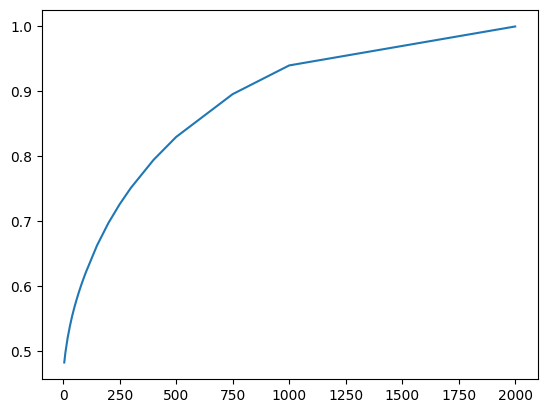

In [55]:
aux_opt.pc.plot()